SOMMAIRE

0. Exploration rapide des données
1. Exploration préliminaire sur 4 classes - Métrique accuracy
2. RandomSearch - 4 classes - Plusieurs métriques
4. GridSearch - 4 classes - Métrique : F1 macro
5. GridSearch - 4 classes - Métrique : F1 classe 2

## 0. Exploration rapide des données

In [6]:
# Import des librairies

# Librairies standard
import pandas as pd
import numpy as np
import joblib as jl
import time
import shap

# Modules Scikit-learn de preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# Modules Scikit-learn pour les métriques
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

# Modules Scikit-learn pour les modèles
from sklearn.tree import DecisionTreeClassifier

# Modules de sampling
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [11]:
# Import du fichier
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [12]:
# Affichage du dataframe
df_tree.head(10)

,Num_Acc,grav,nb_veh,mois_2,mois_3,mois_4,mois_5,mois_6,mois_7,mois_8,...,age_cond_8-13,age_cond_95-plus,sexe_cond_2.0,age_usag_11-17,age_usag_18-24,age_usag_25-64,age_usag_3-6,age_usag_65-74,age_usag_7-10,age_usag_75-plus
0,201800000001,3.0,0.117620,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,201800000001,1.0,0.117620,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,201800000002,1.0,-1.083406,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,201800000003,3.0,-1.083406,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,201800000004,1.0,-1.083406,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,201800000005,4.0,0.117620,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
6,201800000005,1.0,0.117620,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
7,201800000007,3.0,-1.083406,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,201800000008,1.0,-1.083406,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,201800000009,4.0,-1.083406,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
# informations globales
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423136 entries, 0 to 423135
Columns: 183 entries, Num_Acc to age_usag_75-plus
dtypes: float64(2), int64(181)
memory usage: 590.8 MB


In [14]:
# Comptage des valeurs distinctes de la colonne cible 'grav'
comptage_valeurs = df_tree['grav'].value_counts()
print(comptage_valeurs)

1.0    179634
4.0    165868
3.0     66669
2.0     10965
Name: grav, dtype: int64


In [15]:
# Les 4 classes constituant la cible sont assez déséquilibrées, il convient de les rééquilibrer dans un premier temps.

# La classe 1 contient 179634 entrées, donc après un oversample nous aurons 4*179634=718536 entrées ou 10965 pour un undersample

# Pour mémoire, nous avons les significations suivantes des classes de sortie :
# 1 – Indemne
# 2 – Tué
# 3 – Blessé hospitalisé
# 4 – Blessé léger

In [16]:
# Préparation : création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

## 1. Exploration préliminaire sur 4 classes - Métrique accuracy

In [17]:
# Le but de ce chapique est d'explorer et jouer avec le DecisionTree, de façon totalement empirique afin d'explorer les données et le comportement de l'algorithme
# L'idée est d'apprécier les résultats "à la louche" et de voir si des variables ou paramètres sortent du lot, sur les données initiales sur 4 classes
# Une approche plus méthologique sera suivie à compter du chapitre 2 qui débutera sur une étude binaire, puis suivra une étude multi-classe
# NB : la métrique accuracy n'a été utilisée comme métrique par défaut. Par la suite nous nous focaliseront sur F1 macro et F1 sur la classe 2

In [18]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [19]:
# OVERSAMPLING de X_Train et y_train
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

In [20]:
# NB : Des simulations ont été réalisées avec l'Undersampling, et l'accuracy était au mieux de 0,49 sur F1 (Soit pas mieux que le lancé d'une pièce).
# Donc, pour traiter le déséquilibre, seul l'oversampling sera considéré par la suite, il donne des résultats légèrement meilleur vers 0,6 environ

### Algorithme et méthode

Nous utilisation l'agorithme DecisionTreeClassifier de sklearn, donc la documentation est disponible ici :
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
https://scikit-learn.org/stable/modules/model_evaluation.html


In [ ]:
# DecisionTreeClassifier(
#*     criterion='gini',                 # 'gini'  'entropy' 
#*     splitter='best',                  # 'best'  'random'  
#*     max_depth=8,                      # 2,4,8,16,32 None 
#*     min_samples_split=2,              # 2 by default  2,4,8,16,32 
#*     min_samples_leaf=1,               # 1 by default  2,4,8,16,32 
#*     min_weight_fraction_leaf=0.0,     # Ne pas toucher à ce paramètre car supprime des classes dans la prediction
#*     max_features=None,                # Default = None    “auto” n'est plus utilisé, restent “sqrt” et “log2”.
#*     random_state=123,                 # 12 ou 123 
#     max_leaf_nodes=None,              # Default = None  (illimité)
#     min_impurity_decrease=0.0,        # Default = 0.0
#*     class_weight=None,                # Default = None
#*     ccp_alpha=0.0                     # Default = 0.0
# )

In [ ]:
# Le but de cette partie 1 est de se concentrer sur la métrique Accucary et d'améliorer celle-ci en optimisant les paramètres du modèle DecisionTreeClassifier
# Pour cela l'approche a été assez empirique et a consitué à faire varier ces paramètres, puis à regarder l'impact en sortie sur l'Accuracy

# Les observations suivantes ont été faites lors des essais sur les paramètres suivants :

# ccp_alpha : augmentation de l'accuracy, mais au prix de pertes de classes en sorties. Plus on augmente cette valeur plus accuracy s'améliore, mais plus on perd de classes
#            >> Ce paramètre restera à sa valeur par défaut pour la suite

# min_weight_fraction_leaf : Comme pour le paramètre précédant, il supprime des classes dans la prédiction.
#            >> Ce paramètre restera à sa valeur par défaut pour la suite

# class_weight : Ce paramètre permet d'accorder plus de poids à certaines classes. Or nous avons déjà rééquilibré les classes par un Oversampling et ne souhaitons pas privilégier une classe plus qu'une autre
#            >> Ce paramètre restera à sa valeur par défaut pour la suite

# max_leaf_nodes : Ce paramètre permet de déterminer un nombre maximum de noeuds dans l'arbre décision. Compte tenu du nombre de variables et du nombre de valeurs possibles pour chacune d'elles cela donne
#                  un nombre exessivement grand de possibilités
#            >> Ce paramètre restera à sa valeur par défaut pour la suite (none=illimité)

# min_impurity_decrease : valeur qui entraine une scission au niveau d'un noeud selon que la valeur de l'impureté est supérieur ou inférieur à cette valeur saisie. Cela n'est pas utile pour une classification
#                  multi-classe. Pour une classification binaire, ce paramètre à lui seul peut faire l'objet d'une étude de longue haleine, et pour du fine-tuning.
#                  En pratique nous l'allons pas utiliser ce paramètre ici dans ce cas d'école sur les données des accidents
#            >> Ce paramètre restera à sa valeur par défaut pour la suite

In [ ]:
# Au final, on peut considérer que les paramètres précédant ne seront pas privilégiés, puisqu'ils restent à leurs valeurs par défaut.
# Pour les autres paramètres, nous allons les faire varier et utiliser GridSearchCV afin de voir quels sont ceux qui donnent les meilleurs résultats.
# Pour cette partie empirique (partie 1) On ne va pas faire varier tous les paramètres en même temps, mais y aller progressivement en optimisant 
# paramètre par paramètre avant d'en ajouter au fur et à mesure.
# L'approche sera différente dans les autres parties où l'ensemble des paramètres retenus seront optimisés simultanément par un RandomSearch ou GridSearch

In [ ]:
# Les paramètres pris en considération sont donc:






### 1.2 - GridsearchCV (1ère itération)

In [21]:
# Grille de paramètres
param_grid = {'criterion' : ['gini', 'entropy'],
              'splitter' : ['best', 'random'],
              'max_depth' : [12, 14, 16, 18, 20, 22, 24],
              'min_samples_split' : [2, 4, 8, 16, 32, 64],
              'max_features': ['sqrt', 'log2'],
               'random_state': [123]
             }

In [22]:
# Instanciation de l'algorithme
tree_class = DecisionTreeClassifier()

In [23]:
# Instanciation du gridsearch
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')
# grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='f1', error_score='raise')      # F1 ne marche que pour classification binaire, sinon utiliser macro ou micro

In [18]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 2459.532152414322 secondes


In [19]:
# Recheche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 22,
 'max_features': 'sqrt',
 'min_samples_split': 64,
 'random_state': 123,
 'splitter': 'random'}

In [24]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt', min_samples_split=64, random_state=123, splitter='random')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt',
                       min_samples_split=64, random_state=123,
                       splitter='random')

In [25]:
# Sauvegarde 11
filename_11 = 'dt_clf_11.pkl'
jl.dump(dt_clf, filename_11)

['dt_clf_10.pkl']

In [ ]:
# # Chargement du modèle
# loaded_model = joblib.load(filename)          # Charger le modèle à partir du fichier
# y_pred = loaded_model.predict(X_test)         # Utiliser le modèle chargé pour faire des prédictions       

In [26]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,28509,39,1105,6338
2.0,358,96,1085,697
3.0,2084,152,4686,6418
4.0,9815,79,3409,19758


### 1.2 - 1ère itération : résultats

In [2]:
# Métriques individuelles : pas utilisé

# accuracy = metrics.accuracy_score(y_pred, y_test)
# precision = metrics.precision_score(y_test, y_pred, average='macro')  # 'macro' , 'micro' ou 'weighted'
# recall = metrics.recall_score(y_test, y_pred, average='macro')
# f1 = metrics.f1_score(y_test, y_pred, average='macro')

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")

In [38]:
# Rapport de classification : Test
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         1.0       0.70      0.79      0.74     35991
         2.0       0.26      0.04      0.07      2236
         3.0       0.46      0.35      0.40     13340
         4.0       0.59      0.60      0.60     33061

    accuracy                           0.63     84628
   macro avg       0.50      0.45      0.45     84628
weighted avg       0.61      0.63      0.61     84628



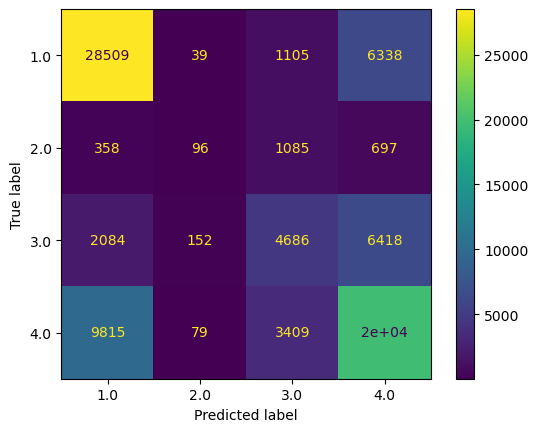

In [39]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test);

In [40]:
# Stockage dans l'array feats, des features (caratérisques) importantes (les plus déterminantes)
feats = {}
for feature, importance in zip(X.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
# Transformation en fd, puis tri    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(10)

,Importance
catv_1.0,0.150887
obsm_1.0,0.108877
agg_2,0.049717
secu1_4.0,0.044760
catv_4.0,0.039861
catv_3.0,0.034768
obsm_2.0,0.031345
catv_2.0,0.029142
col_2.0,0.028784
catu_3,0.024052


In [46]:
# Rapport de classification : Test - réaffichage
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.70      0.79      0.74     35991
         2.0       0.26      0.04      0.07      2236
         3.0       0.46      0.35      0.40     13340
         4.0       0.59      0.60      0.60     33061

    accuracy                           0.63     84628
   macro avg       0.50      0.45      0.45     84628
weighted avg       0.61      0.63      0.61     84628



In [ ]:
# On remarque une plus grande difficulté à prédire les classes 2 et 3 (tués et hospitalisés) et une meilleure précision sur les classes 1 et 4 (indemne et blessé léger)

In [41]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraire les colonnes pertinentes du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
colonnes_parametres.append('mean_test_score')
resultat = resultats[colonnes_parametres]

# Renommer les colonnes
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres[:-1]]
noms_parametres.append('Accuracy')
resultat.columns = noms_parametres

# Afficher le dataframe de résultats
resultat = resultat.sort_values(by='Accuracy', ascending=False)
resultat.head(10)

,criterion,max_depth,max_features,min_samples_split,random_state,splitter,Accuracy
299,entropy,22,sqrt,64,123,random,0.627359
323,entropy,24,sqrt,64,123,random,0.625740
130,gini,22,sqrt,64,123,best,0.625545
82,gini,18,sqrt,64,123,best,0.625374
275,entropy,20,sqrt,64,123,random,0.625149
154,gini,24,sqrt,64,123,best,0.624877
106,gini,20,sqrt,64,123,best,0.624626
247,entropy,18,sqrt,16,123,random,0.623628
56,gini,16,sqrt,32,123,best,0.623566
298,entropy,22,sqrt,64,123,best,0.623542


In [23]:
# On note que : 
# 
# criterion = gini & entropy sont à parité dans le Top10 > on conserve les deux
# param_max_depth = 24 donne le meilleur résultat > à optimiser
# param_max_features = sqrt donne de meilleurs résultats dans l'ensemble > à conserver
# param_min_samples_split faible donne le meilleur résultat > à optimiser
# param_splitter = best donne de meilleurs résultats dans l'ensemble > à conserver
# param_random_state = constante > à variabiliser et optimiser

### 1.3 - 1ère itération : graphiques

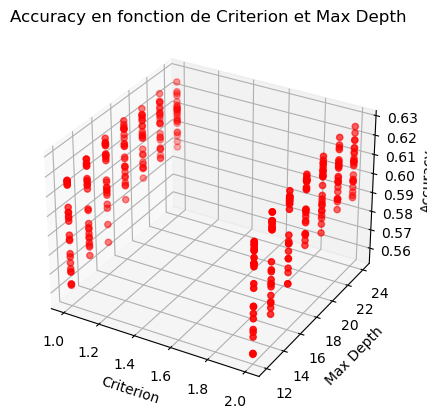

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assurez-vous d'avoir 'resultat' contenant les colonnes 'criterion', 'max_depth' et 'Accuracy'

# # Conversion des valeurs 'gini' en 1 et 'entropy' en 2
# resultat['criterion'] = resultat['criterion'].map({'gini': 1, 'entropy': 2})
# Conversion des valeurs 'gini' en 1 et 'entropy' en 2
resultat.loc[resultat['criterion'] == 'gini', 'criterion'] = 1
resultat.loc[resultat['criterion'] == 'entropy', 'criterion'] = 2

# Créer une figure en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extraire les valeurs des paramètres et de l'accuracy
criterion_values = resultat['criterion']
max_depth_values = resultat['max_depth']
accuracy_values = resultat['Accuracy']
min_sample_split_values = resultat['min_samples_split']
splitter_values = resultat['splitter']

# Tracer le graphique en 3D
ax.scatter(criterion_values, max_depth_values, accuracy_values, c='r', marker='o')

# Ajouter des labels et un titre
ax.set_xlabel('Criterion')
ax.set_ylabel('Max Depth')
ax.set_zlabel('Accuracy')
ax.set_title('Accuracy en fonction de Criterion et Max Depth')

# Afficher le graphique
plt.show()

In [ ]:
# Les différences sont peu notables entre criterion = 1 (gini) et criterion = 2 (entropy)
# On va donc afficher des tranches sont forme de graphs 2D pour mieux visualiser les paramètres et leur impacts sur l'Accuracy

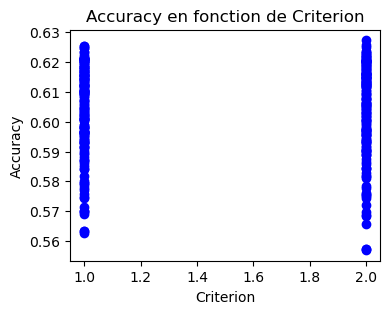

In [43]:
# Création du scatter plot : Accuracy VS criterion
plt.figure(figsize=(4, 3))
plt.scatter(resultat['criterion'], resultat['Accuracy'], color='blue', marker='o')
plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de Criterion')

# Affichage du scatter plot
plt.show()

In [ ]:
# On note une accuracy légèrement meilleurs pour criterion = gini, ce qui était déjà visible dans le tableau

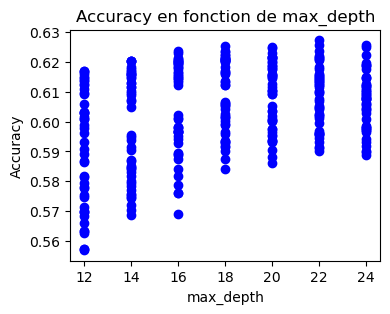

In [44]:
# Création du scatter plot : Accuracy VS max_depth
plt.figure(figsize=(4, 3))
plt.scatter(resultat['max_depth'], resultat['Accuracy'], color='blue', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de max_depth')

# Affichage du scatter plot
plt.show()

In [45]:
# On note qu'une augmentation de max_depth améliore significativement l'Accuracy

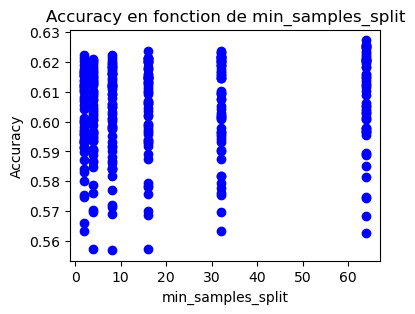

In [51]:
# Création du scatter plot : Accuracy VS min_samples_split
plt.figure(figsize=(4, 3))
plt.scatter(resultat['min_samples_split'], resultat['Accuracy'], color='blue', marker='o')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de min_samples_split')

# Affichage du scatter plot
plt.show()

In [ ]:
# Plus min_samples_split est faible meilleur est l'Accuracy, mais ne n'est pas d'une différence énorme non plus

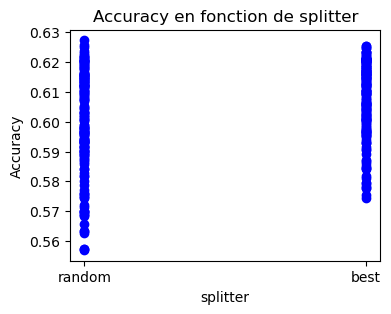

In [46]:
# Création du scatter plot : Accuracy VS splitter
plt.figure(figsize=(4, 3))
plt.scatter(resultat['splitter'], resultat['Accuracy'], color='blue', marker='o')
plt.xlabel('splitter')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de splitter')

# Affichage du scatter plot
plt.show()

In [ ]:
# Le splitter place à best permet de donner une Accuracy légèrement meilleur, mais l'étalement des résultats est aussi un peu élévé qu'avec random.

### 1.4 - GridsearchCV (2ème itération)

In [50]:
# Grille de paramètres basée sur les résultats précédents
param_grid = {'criterion' : ['gini', 'entropy'],
              'splitter' : ['best', 'random'],
              'max_depth' : [18, 20, 22, 24, 28, 32, 64],
              'min_samples_split' : [64],
              'max_features': ['sqrt'],
               'random_state': [16, 128, 256, 512, 1024]
             }

In [54]:
# On cherche à optimiser les paramètres de la première étape, avant d'en ajouter de nouveaux

In [51]:
# Instanciation de l'algorithme et du gridsearch
tree_class = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')

In [52]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 358.50118350982666 secondes


In [66]:
# Recheche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 22,
 'max_features': 'sqrt',
 'min_samples_leaf': 32,
 'min_samples_split': 64,
 'random_state': 16,
 'splitter': 'best'}

In [55]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt', min_samples_split=64, random_state=16, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt',
                       min_samples_split=64, random_state=16)

In [56]:
# Sauvegarde 12
filename_12 = 'dt_clf_12.pkl'
jl.dump(dt_clf, filename_12)

['dt_clf_02.pkl']

In [ ]:
# # Chargement du modèle
# dt_clf = joblib.load(filename_02)          # Charger le modèle à partir du fichier
# y_pred = loaded_model.predict(X_test)         # Utiliser le modèle chargé pour faire des prédictions   

In [57]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,29564,33,988,5406
2.0,410,73,1060,693
3.0,2620,143,4377,6200
4.0,10942,113,2955,19051


### 1.5 - 2ème itération : résultats

In [58]:
# Affichage accuracy
accuracy = metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6270383324667959


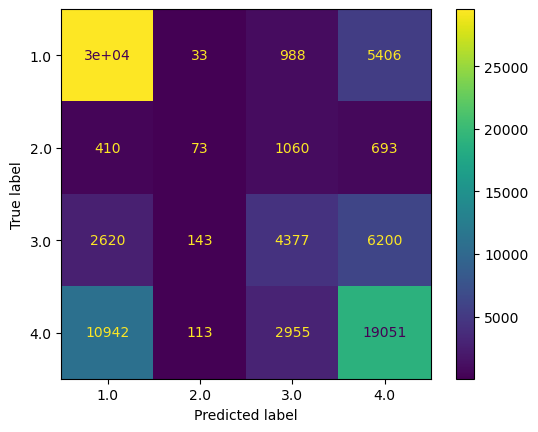

In [59]:
# Affichage de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test);

In [60]:
# Affichage du rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.68      0.82      0.74     35991
         2.0       0.20      0.03      0.06      2236
         3.0       0.47      0.33      0.39     13340
         4.0       0.61      0.58      0.59     33061

    accuracy                           0.63     84628
   macro avg       0.49      0.44      0.44     84628
weighted avg       0.61      0.63      0.61     84628



In [ ]:
# Si lors compare les résultats de la deuxième itérations, ci-dessous, avec la première itération ci-dessous, on note que :
# L'accuracy et le f1-score ont progressé au global et pour chaque classes à l'exception de la classe 1 (tués) moins bien prédite

# Résultat lors de la première itération:

#               precision    recall  f1-score   support

#          1.0       0.64      0.75      0.69     36071
#          2.0       0.65      0.81      0.72     36150
#          3.0       0.52      0.45      0.48     35693
#          4.0       0.56      0.40      0.46     35794

#     accuracy                           0.60    143708
#    macro avg       0.59      0.60      0.59    143708
# weighted avg       0.59      0.60      0.59    143708

In [61]:
# Stockage dans l'array feats, des features (caratérisques) importantes (les plus déterminantes)
feats = {}
for feature, importance in zip(X.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
# Transformation en fd, puis tri    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(10)

,Importance
secu1_2.0,0.211257
secu1_4.0,0.083646
agg_2,0.074103
nb_veh,0.039926
obsm_1.0,0.037356
catu_2,0.033046
col_3.0,0.024483
col_2.0,0.023875
place_3.0,0.020739
manv_13.0,0.018861


In [ ]:
# Si l'on compare la 2ème itération, ci_dessus, avec la première itération, ci-dessous, on remarque que les variables jugés importantes ne sont plus du tout les mêmes.
# Ainsi, si les nouveaux paramètres d'optimisation ont permi de favoriser l'accuracy sur les classes 2 et 4, cela s'est fait au détriment de la classe 1.
# Par la-même l'algorithme a favorisé d'autres variables explicatives

# 	Importance
# catu_3	0.057360
# catv_3.0	0.046060
# obsm_2.0	0.045080
# agg_2	0.034743
# col_4.0	0.034546
# catr_4	0.032271
# catv_1.0	0.031113
# obsm_1.0	0.029901
# nb_veh	0.027352
# catv_2.0	0.022980

In [62]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraire les colonnes pertinentes du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
colonnes_parametres.append('mean_test_score')
resultat = resultats[colonnes_parametres]

# Renommer les colonnes
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres[:-1]]
noms_parametres.append('Accuracy')
resultat.columns = noms_parametres

# Afficher le dataframe de résultats
resultat = resultat.sort_values(by='Accuracy', ascending=False)
resultat.head(10)

,criterion,max_depth,max_features,min_samples_split,random_state,splitter,Accuracy
90,entropy,22,sqrt,64,16,best,0.625758
29,gini,22,sqrt,64,1024,random,0.625403
100,entropy,24,sqrt,64,16,best,0.625043
9,gini,18,sqrt,64,1024,random,0.625013
32,gini,24,sqrt,64,128,best,0.624641
70,entropy,18,sqrt,64,16,best,0.624233
73,entropy,18,sqrt,64,128,random,0.624124
97,entropy,22,sqrt,64,512,random,0.623941
19,gini,20,sqrt,64,1024,random,0.623879
109,entropy,24,sqrt,64,1024,random,0.623764


In [ ]:
# La table de résultat nous montre que le random state n'influe quasiment pas > on le fixera à 256 par la suite
# On note aussi que plus le random split est faible meilleur est l'accuracy > on le fixera à 2 ou 4 par la suite 

# Aucun graphique n'est nécessaire pour cette 2ème itération

### 1.6 - GridsearchCV (3ème itération)

In [7]:
# Grille de paramètres
param_grid = {'criterion' : ['entropy'],
              'splitter' : ['best'],
              'max_depth' : [22],
              'min_samples_split' : [64],
              'min_samples_leaf' : [1, 2, 4, 8, 16, 32, 64, 128, 256],
              'max_features': ['sqrt'],
               'random_state': [16]
             }

In [8]:
# Instanciation de l'algorithme et du gridsearch
tree_class = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')

In [9]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 22.35978627204895 secondes


In [10]:
# Recheche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 22,
 'max_features': 'sqrt',
 'min_samples_leaf': 32,
 'min_samples_split': 64,
 'random_state': 16,
 'splitter': 'best'}

In [11]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt', min_samples_leaf=32, min_samples_split=64, random_state=16, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt',
                       min_samples_leaf=32, min_samples_split=64,
                       random_state=16)

In [12]:
# Sauvegarde 13
filename_13 = 'dt_clf_13.pkl'
jl.dump(dt_clf, filename_13)

['dt_clf_03.pkl']

In [13]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=64, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, random_state=256, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,24298,308,2221,9164
2.0,358,281,855,742
3.0,2333,849,4570,5588
4.0,9418,739,5666,17238


### 1.7 - 3ème itération : résultats

In [22]:
# Affichage accuracy
accuracy = metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.686099590836975


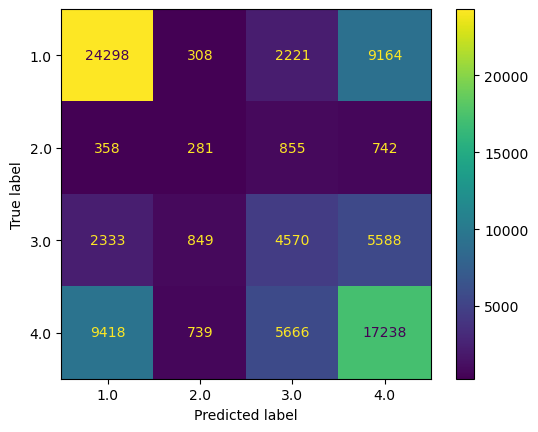

In [15]:
# Affichage de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test);

In [16]:
# Affichage du rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.67      0.68      0.67     35991
         2.0       0.13      0.13      0.13      2236
         3.0       0.34      0.34      0.34     13340
         4.0       0.53      0.52      0.52     33061

    accuracy                           0.55     84628
   macro avg       0.42      0.42      0.42     84628
weighted avg       0.55      0.55      0.55     84628



In [17]:
# Stockage dans l'array feats, des features (caratérisques) importantes (les plus déterminantes)
feats = {}
for feature, importance in zip(X.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
# Transformation en fd, puis tri    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(10)

,Importance
catv_1.0,0.033106
place_3.0,0.027497
secu1_2.0,0.027284
nb_veh,0.021708
catv_3.0,0.021213
obsm_1.0,0.019293
weekend_1,0.016548
agg_2,0.016187
catv_2.0,0.015580
manv_1.0,0.015051


In [ ]:
# 	Importance
# col_4.0	0.028442
# secu1_2.0	0.026565
# nb_veh	0.023578
# agg_2	0.022435
# catr_4	0.018263
# catv_1.0	0.017753
# trajet_2.0	0.016460
# weekend_1	0.016224
# choc_1.0	0.015875
# int_3.0	0.015556

In [ ]:
# Les variables explicatives sont majoritairement les mêmes que lors de la deuxième itération.

In [18]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraire les colonnes pertinentes du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
colonnes_parametres.append('mean_test_score')
resultat = resultats[colonnes_parametres]

# Renommer les colonnes
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres[:-1]]
noms_parametres.append('Accuracy')
resultat.columns = noms_parametres

# Afficher le dataframe de résultats
resultat = resultat.sort_values(by='Accuracy', ascending=False)
resultat.head(10)

,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,random_state,splitter,Accuracy
5,entropy,22,sqrt,32,64,16,best,0.627226
3,entropy,22,sqrt,8,64,16,best,0.626452
4,entropy,22,sqrt,16,64,16,best,0.626145
2,entropy,22,sqrt,4,64,16,best,0.625941
0,entropy,22,sqrt,1,64,16,best,0.625758
1,entropy,22,sqrt,2,64,16,best,0.623699
6,entropy,22,sqrt,64,64,16,best,0.622098
7,entropy,22,sqrt,128,64,16,best,0.619380
8,entropy,22,sqrt,256,64,16,best,0.612272


### 1.8 - RandomizedSearchCV 1

In [21]:
# Définir les hyperparamètres et leurs distributions pour la recherche
param_dist = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + list(np.arange(1, 100, 10)),
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": np.arange(2, 100, 10),
    "min_samples_leaf": np.arange(1, 100,10),
    "random_state": np.arange(1, 256, 64)
}

In [26]:
# Instanciation de l'algorithme et du RandomizedSearchCV
tree_class = DecisionTreeClassifier()
# grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')
random_search = RandomizedSearchCV(tree_class, param_distributions=param_dist,
                                   n_iter=10000, cv=3, verbose=1, 
                                   n_jobs=-1)

In [27]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

random_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Fitting 3 folds for each of 10000 candidates, totalling 30000 fits
Temps d'exécution : 6577.2313594818115 secondes


In [28]:
# Recherche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 22,
 'max_features': 'sqrt',
 'min_samples_leaf': 32,
 'min_samples_split': 64,
 'random_state': 16,
 'splitter': 'best'}

In [29]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt', min_samples_leaf=32, min_samples_split=64, random_state=16, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt',
                       min_samples_leaf=32, min_samples_split=64,
                       random_state=16)

In [30]:
# Sauvegarde 14
filename_random = 'dt_clf_14_random.pkl'
jl.dump(dt_clf, filename_random)

['dt_clf_bal_random.pkl']

In [31]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,28981,5,855,6150
2.0,417,23,1002,794
3.0,2291,32,4387,6630
4.0,10529,23,2837,19672


In [32]:
# Affichage accuracy
accuracy = metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6270146996266012


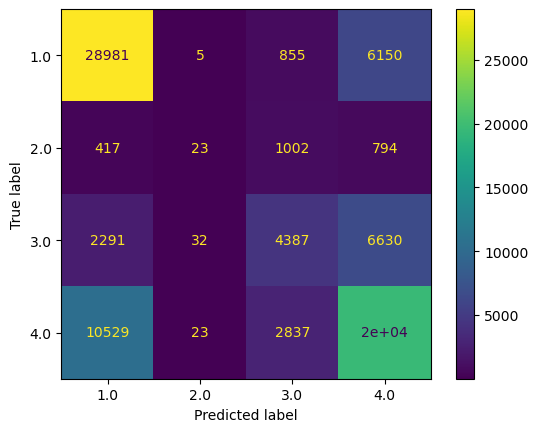

In [33]:
# Affichage matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test);

### 1.9 - RandomizedSearchCV 2

In [27]:
# Définir les hyperparamètres et leurs distributions pour la recherche
param_dist = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + list(np.arange(1, 100, 10)),
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": np.arange(2, 100, 10),
    "min_samples_leaf": np.arange(1, 100,10),
    "random_state": np.arange(1, 256, 64)
}

In [28]:
# Instanciation de l'algorithme et du RandomizedSearchCV
tree_class = DecisionTreeClassifier()
# grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')
random_search = RandomizedSearchCV(tree_class, param_distributions=param_dist, scoring='f1_macro', n_iter=1000, cv=3, verbose=1, n_jobs=-1)

In [29]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

random_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
Temps d'exécution : 514.6564199924469 secondes


In [31]:
# Recherche des meilleurs paramètres
final_model = random_search.best_params_
final_model

{'splitter': 'best',
 'random_state': 65,
 'min_samples_split': 62,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 31,
 'criterion': 'entropy'}

In [32]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=31, max_features='sqrt', min_samples_leaf=1, min_samples_split=62, random_state=65, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=31, max_features='sqrt',
                       min_samples_split=62, random_state=65)

In [34]:
# Sauvegarde 15
filename_random = 'dt_clf_15_random.pkl'
jl.dump(dt_clf, filename_random)

['dt_clf_15_random.pkl']

In [35]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,28632,52,1122,6185
2.0,381,121,984,750
3.0,2262,220,4520,6338
4.0,10242,153,3391,19275


In [36]:
# Affichage accuracy
accuracy = metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6209292432764569


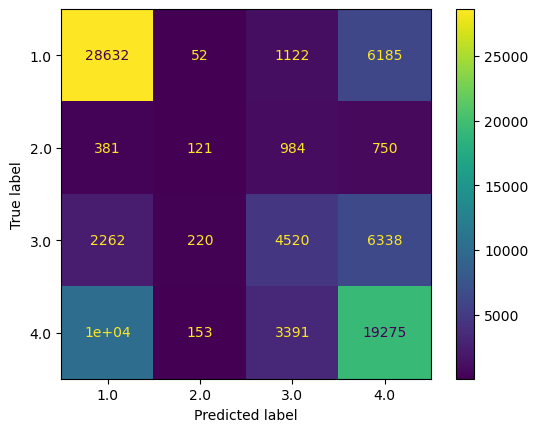

In [37]:
# Affichage matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test);

### 2.0 - RandomSearch - 4 classes - Plusieurs métriques

In [63]:
# Import des librairies

# Librairies standard
import pandas as pd
import numpy as np
import joblib as jl
import time
import shap

# Modules Scikit-learn de preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# Modules Scikit-learn pour les métriques
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

# Modules Scikit-learn pour les modèles
from sklearn.tree import DecisionTreeClassifier

# Modules de sampling
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [64]:
# Import du fichiers
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [65]:
# Création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

In [66]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [67]:
# OVERSAMPLING
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

In [68]:
# Définition d'une métriques personnalisés
def my_metric(y_true, y_pred):
    f1_score_class_2 = f1_score(y_true, y_pred, labels=[2], average=None)[0]
    f1_score_class_3 = f1_score(y_true, y_pred, labels=[3], average=None)[0]
    return (1.5 * f1_score_class_2 + f1_score_class_3) / 2.5

In [69]:
# Choix des scoring
scoring = {
    'MCC': make_scorer(matthews_corrcoef),
    'F1': make_scorer(f1_score, average='macro'),
    'Cust_metric': make_scorer(my_metric),
    'F1_class_2': make_scorer(f1_score, labels=[2], average=None)
}

In [70]:
# Définition des hyperparamètres et leurs distributions pour la recherche
param_dist = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + list(np.arange(2, 32, 2)),     #[12, 14, 16, 18, 20, 22, 24]
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": np.arange(2, 100, 10),          #[1, 2, 4, 8, 16, 32, 64, 128, 256]
    "min_samples_leaf": np.arange(1, 100,10),            #[1, 2, 4, 8, 16, 32, 64, 128, 256]
    "random_state": np.arange(1, 256, 64)                #
}

In [62]:
# Instanciation de l'algorithme et du RandomizedSearchCV
tree_class = DecisionTreeClassifier()
# grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')
total_iterations = 1000
random_search = RandomizedSearchCV(tree_class, param_distributions=param_dist, scoring=scoring, n_iter=total_iterations, cv=3, verbose=2, n_jobs=-1, refit=False)

In [71]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

random_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
Temps d'exécution : 753.2940034866333 secondes


In [74]:
# # Sauvegarde 20 random search
# filename_20 = 'rand_search_20.pkl'
# jl.dump(random_search, filename_20)

In [ ]:
# # Récupération du modèle depuis sauvegarde 20 grid_search
# random_search = jl.load('rand_search_20.pkl')

In [ ]:
### Tableau de résultats > Sauvegarde

In [ ]:
# Sélection des colonnes pertinentes
results_df = pd.DataFrame(random_search.cv_results_)
selected_columns = ['params'] + [f'mean_test_{metric}' for metric in scoring]
results_df = results_df[selected_columns]

In [ ]:
# Récupération des résultats obtenus par randomsearch
resultats = pd.DataFrame(random_search.cv_results_)

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
df_param = resultats[colonnes_parametres]

# Renommage des colonnes de df_param
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres]
df_param.columns = noms_parametres

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_scoring = [col for col in resultats.columns if col.startswith('mean_test_')]
df_scoring = resultats[colonnes_scoring]

# Renommage des colonnes de df_scoring
noms_scoring = [col.replace('mean_test_', '') for col in colonnes_scoring]
df_scoring.columns = noms_scoring

# Concatenation des deux dataframe
df_resultat = pd.concat([df_param, df_scoring], axis=1)
df_resultat.head(10)

In [85]:
# Sauvegarde des résultats
df_resultat.to_csv('dt_files/resultat_20.csv', index=False)

In [86]:
# Index des maxima des différents scoring
index_max_MCC = df_resultat['MCC'].idxmax()
index_max_F1 = df_resultat['F1'].idxmax()
index_max_cust = df_resultat['Cust_metric'].idxmax()
index_max_class2 = df_resultat['F1_class_2'].idxmax()

# Extraction des lignes correspondantesindex_max_class2
df_resultat_max = df_resultat.loc[[index_max_MCC, index_max_F1, index_max_cust, index_max_class2]]
# df_resultat_max = df_resultat_max.drop_duplicates()

# Affichage
df_resultat_max.head()

,splitter,random_state,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,MCC,F1,Cust_metric,F1_class_2
599,best,193,82,11,sqrt,24,entropy,0.399604,0.442709,0.183200,0.045360
862,best,65,22,1,sqrt,30,entropy,0.375568,0.446841,0.215605,0.108203
596,best,65,2,1,sqrt,28,entropy,0.353960,0.440313,0.220304,0.124650
596,best,65,2,1,sqrt,28,entropy,0.353960,0.440313,0.220304,0.124650


In [87]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params de F1 (2ème ligne)

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt', min_samples_split=22, min_samples_leaf=1, random_state=65, splitter='best') 
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt',
                       min_samples_split=22, random_state=65)

In [88]:
# Sauvegarde 20 - dt_clf
filename_20 = 'dt_clf_20.pkl'
jl.dump(dt_clf, filename_20)

['dt_clf_20.pkl']

In [89]:
# Récupération du modèle depuis sauvegarde 20 dt_clf
dt_clf = jl.load('dt_clf_20.pkl')

In [91]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,28989,71,1055,5876
2.0,364,129,1011,732
3.0,2375,284,4547,6134
4.0,10617,196,3472,18776


In [90]:
## Evaluation rapide des scores
# Évaluation sur l'ensemble d'entraînement
train_preds = dt_clf.predict(X_train)
train_f1 = f1_score(y_train, train_preds, average='macro')

# Évaluation sur l'ensemble de validation
test_preds = dt_clf.predict(X_test)
test_f1 = f1_score(y_test, test_preds, average='macro')

print(f"Train F1 score (macro): {train_f1 * 100:.2f}%")
print(f"Validation F1 score (macro): {test_f1 * 100:.2f}%")

Train F1 score (macro): 54.15%
Validation F1 score (macro): 44.96%


In [ ]:
### TRAIN > Evaluations

In [92]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_train, train_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,120966,138,3180,19359
2.0,1286,1481,3466,2496
3.0,8552,613,22900,21264
4.0,38207,492,10629,83479


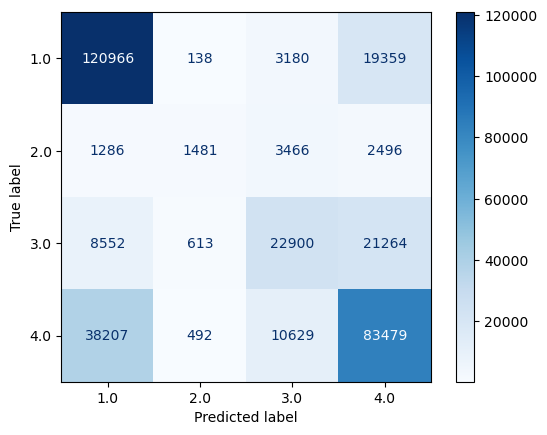

In [95]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_train,y_train,cmap=plt.cm.Blues);

In [96]:
# Rapport de classification
report_train = metrics.classification_report(y_train, train_preds)
print(report_train)

              precision    recall  f1-score   support

         1.0       0.72      0.84      0.77    143643
         2.0       0.54      0.17      0.26      8729
         3.0       0.57      0.43      0.49     53329
         4.0       0.66      0.63      0.64    132807

    accuracy                           0.68    338508
   macro avg       0.62      0.52      0.54    338508
weighted avg       0.67      0.68      0.66    338508



In [ ]:
### TEST > Evaluations

In [97]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_train, train_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,120966,138,3180,19359
2.0,1286,1481,3466,2496
3.0,8552,613,22900,21264
4.0,38207,492,10629,83479


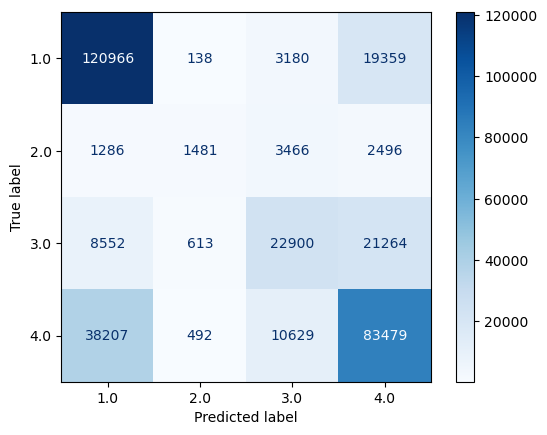

In [99]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_train,y_train,cmap=plt.cm.Blues);

In [105]:
# Rapport de classification
report_test = metrics.classification_report(y_test, test_preds)
print(report_test)

              precision    recall  f1-score   support

         1.0       0.68      0.81      0.74     35991
         2.0       0.19      0.06      0.09      2236
         3.0       0.45      0.34      0.39     13340
         4.0       0.60      0.57      0.58     33061

    accuracy                           0.62     84628
   macro avg       0.48      0.44      0.45     84628
weighted avg       0.60      0.62      0.61     84628



In [108]:
# Rapport de classification Dataframe
df_report_test = pd.DataFrame(metrics.classification_report(y_test, test_preds, output_dict=True))
df_report_test.head(12)

,1.0,2.0,3.0,4.0,accuracy,macro avg,weighted avg
precision,0.684591,0.189706,0.450868,0.595723,0.619665,0.480222,0.599956
recall,0.805451,0.057692,0.340855,0.567920,0.619665,0.442980,0.619665
f1-score,0.740119,0.088477,0.388218,0.581489,0.619665,0.449576,0.605461
support,35991.000000,2236.000000,13340.000000,33061.000000,0.619665,84628.000000,84628.000000


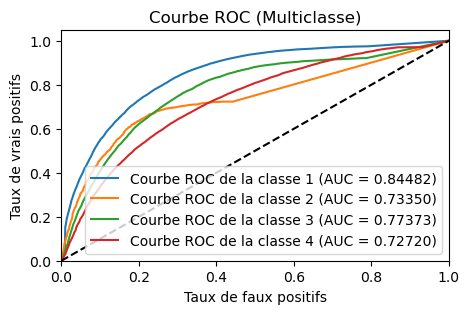

In [109]:
# Courbes ROC

# Binarisation des étiquettes dans un format one-vs-all
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
y_score = dt_clf.predict_proba(X_test)

n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcul de la courbe ROC et de l'AUC pour chaque classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

# Tracer de la courbe ROC pour chaque classe
plt.figure(figsize=(5, 3))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Courbe ROC de la classe {i+1} (AUC = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC (Multiclasse)')
plt.legend(loc="lower right")
plt.show()  

### 3.0 - GridSearch - 4 classes - Métrique : F1 macro

In [131]:
# Import des librairies

# Librairies standard
import pandas as pd
import numpy as np
import joblib as jl
import time
import shap

# Modules Scikit-learn de preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# Modules Scikit-learn pour les métriques
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

# Modules Scikit-learn pour les modèles
from sklearn.tree import DecisionTreeClassifier

# Modules de sampling
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [132]:
# Lecture du fichier commun
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [133]:
# Création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

In [134]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [135]:
# OVERSAMPLING
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

In [136]:
# Définir les hyperparamètres et leurs distributions pour la recherche v2
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + [12, 14, 16, 18, 20, 22, 24, 32, 64],    
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "random_state": [16, 32, 64, 128, 256]                
}


In [7]:
# Instanciation de l'algorithme et du gridsearch
tree_class = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='f1_macro', error_score='raise')

In [8]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 185284.9724023342 secondes


In [51]:
# Sauvegarde 30 grid search
grid_30 = 'grid_search_30.pkl'
jl.dump(grid_search, filename_30)

['dt_clf_30.pkl']

In [137]:
# Récupération du modèle depuis sauvegarde 30 grid_search
grid_search = jl.load('grid_search_30.pkl')

In [52]:
# Affichage du grid search
df_grid_search = pd.DataFrame(grid_search.cv_results_)
df_grid_search.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_random_state,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.189327,0.068646,0.143482,0.004430,gini,None,sqrt,1,1,16,best,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.418857,0.419097,0.417617,0.418524,0.000649,13615
1,1.138077,0.083042,0.150935,0.020761,gini,None,sqrt,1,1,16,random,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.415112,0.410480,0.409642,0.411745,0.002405,17504
2,1.143705,0.014569,0.145885,0.003459,gini,None,sqrt,1,1,32,best,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.418342,0.416171,0.414979,0.416497,0.001392,14714
3,1.144557,0.017911,0.148640,0.000876,gini,None,sqrt,1,1,32,random,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.415503,0.413879,0.414085,0.414489,0.000722,15920
4,1.093108,0.008016,0.141078,0.001186,gini,None,sqrt,1,1,64,best,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.415245,0.419014,0.418011,0.417423,0.001594,14183
5,1.102017,0.021670,0.146919,0.005984,gini,None,sqrt,1,1,64,random,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.412740,0.419514,0.414649,0.415634,0.002852,15277
6,1.148523,0.008480,0.141993,0.005276,gini,None,sqrt,1,1,128,best,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.413312,0.416492,0.416696,0.415500,0.001549,15363
7,1.132004,0.012422,0.141426,0.001774,gini,None,sqrt,1,1,128,random,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.416910,0.414661,0.411478,0.414350,0.002229,15980
8,1.075727,0.026973,0.140098,0.002936,gini,None,sqrt,1,1,256,best,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.418031,0.413460,0.420971,0.417487,0.003091,14139
9,1.015334,0.034684,0.139414,0.015952,gini,None,sqrt,1,1,256,random,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.412003,0.410149,0.410804,0.410985,0.000768,17892


In [10]:
# Recherche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 24,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 16,
 'random_state': 16,
 'splitter': 'best'}

In [11]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=24, max_features='sqrt', min_samples_split=16, random_state=16, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=24, max_features='sqrt',
                       min_samples_split=16, random_state=16)

In [47]:
# Sauvegarde 30 - dt_clf
filename_30 = 'dt_clf_30.pkl'
jl.dump(dt_clf, filename_30)

['dt_clf_30.pkl']

In [46]:
# Récupération du modèle depuis sauvegarde 30 dt_clf
dt_clf = jl.load('dt_clf_30.pkl')

In [41]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,29304,90,979,5618
2.0,407,149,911,769
3.0,2425,335,4265,6315
4.0,10899,242,3382,18538


In [42]:
# Rapport de classification
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         1.0       0.68      0.81      0.74     35991
         2.0       0.18      0.07      0.10      2236
         3.0       0.45      0.32      0.37     13340
         4.0       0.59      0.56      0.58     33061

    accuracy                           0.62     84628
   macro avg       0.48      0.44      0.45     84628
weighted avg       0.60      0.62      0.60     84628



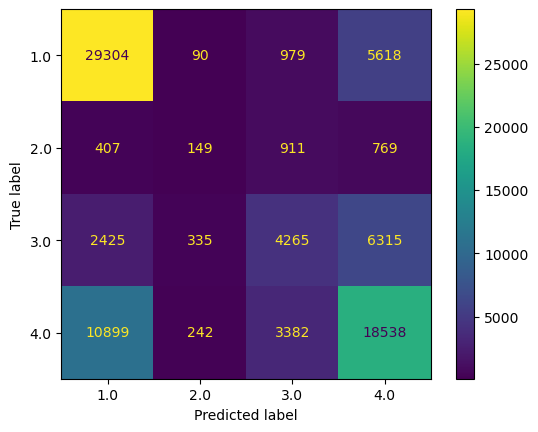

In [43]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test);

In [44]:
## Evaluation rapide des scores
# Évaluation sur l'ensemble d'entraînement
train_preds = dt_clf.predict(X_train)
train_f1 = f1_score(y_train, train_preds, average='macro')

# Évaluation sur l'ensemble de validation
test_preds = dt_clf.predict(X_test)
test_f1 = f1_score(y_test, test_preds, average='macro')

print(f"Train F1 score (macro): {train_f1 * 100:.2f}%")
print(f"Validation F1 score (macro): {test_f1 * 100:.2f}%")

Train F1 score (macro): 56.44%
Validation F1 score (macro): 44.72%


In [ ]:
### TRAIN > Evaluations

In [28]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_train, train_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,122238,134,2672,18599
2.0,1346,1973,2983,2427
3.0,8496,759,23450,20624
4.0,39288,587,9480,83452


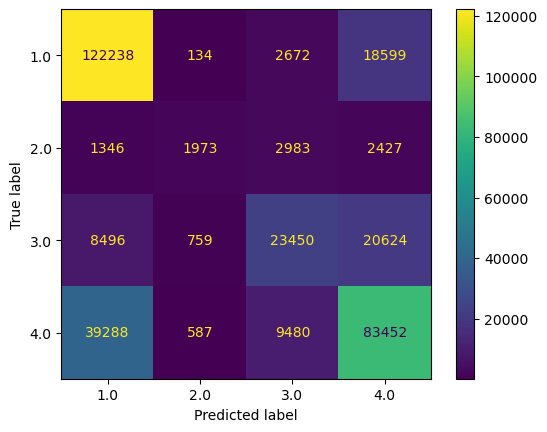

In [29]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_train,y_train);

In [24]:
# Rapport de classification
report_train = metrics.classification_report(y_train, train_preds)
print(report_train)

              precision    recall  f1-score   support

         1.0       0.71      0.85      0.78    143643
         2.0       0.57      0.23      0.32      8729
         3.0       0.61      0.44      0.51     53329
         4.0       0.67      0.63      0.65    132807

    accuracy                           0.68    338508
   macro avg       0.64      0.54      0.56    338508
weighted avg       0.67      0.68      0.67    338508



In [ ]:
### TEST > Evaluations

In [30]:
# Matrice de confusion sur l'ensemble de test
pd.crosstab(y_test, test_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,29304,90,979,5618
2.0,407,149,911,769
3.0,2425,335,4265,6315
4.0,10899,242,3382,18538


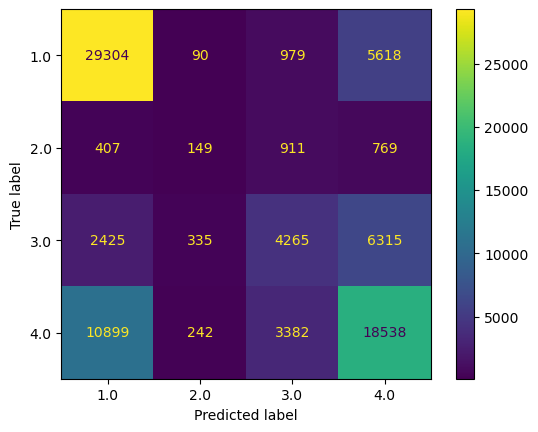

In [32]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test, y_test);

In [33]:
# Rapport de classification
report_test = metrics.classification_report(y_test, test_preds)
print(report_test)

              precision    recall  f1-score   support

         1.0       0.68      0.81      0.74     35991
         2.0       0.18      0.07      0.10      2236
         3.0       0.45      0.32      0.37     13340
         4.0       0.59      0.56      0.58     33061

    accuracy                           0.62     84628
   macro avg       0.48      0.44      0.45     84628
weighted avg       0.60      0.62      0.60     84628



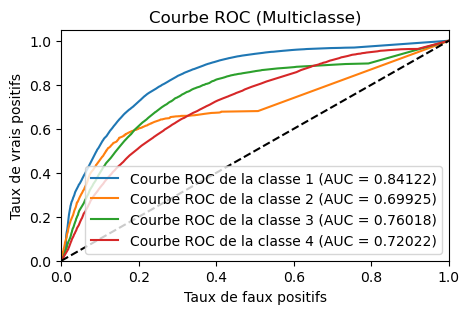

In [45]:
# Courbes ROC

# Binarisation des étiquettes dans un format one-vs-all
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
y_score = dt_clf.predict_proba(X_test)

n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcul de la courbe ROC et de l'AUC pour chaque classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

# Tracer de la courbe ROC pour chaque classe
plt.figure(figsize=(5, 3))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Courbe ROC de la classe {i+1} (AUC = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC (Multiclasse)')
plt.legend(loc="lower right")
plt.show()  

In [ ]:
### Tableau de résultats > Sauvegarde

In [142]:
# Sauvegarde des résultats
df_resultat.to_csv('dt_files/resultat_30.csv', index=False)

### 4.0 - GridSearch - 4 classes - Métrique : F1 classe 2

In [120]:
# Import des librairies

# Librairies standard
import pandas as pd
import numpy as np
import joblib as jl
import time
import shap

# Modules Scikit-learn de preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# Modules Scikit-learn pour les métriques
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

# Modules Scikit-learn pour les modèles
from sklearn.tree import DecisionTreeClassifier

# Modules de sampling
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [121]:
# Lecture du fichier commun
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [122]:
# Création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

In [123]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [124]:
# OVERSAMPLING
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

In [125]:
# Définir les hyperparamètres et leurs distributions pour la recherche v2
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + [12, 14, 16, 18, 20, 22, 24, 32, 64],    
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "random_state": [128]                                               # Peu d'influence, on le fixe à 1 valeur pour réduire le temps d'exécution
}

In [15]:
# Instanciation de l'algorithme et du gridsearch
tree_class = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring=make_scorer(f1_score, labels=[2], average=None), error_score='raise')

In [16]:
# MAIN > Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 15526.885598182678 secondes


In [17]:
# Sauvegarde 40 grid search
grid_40 = 'grid_search_40.pkl'
jl.dump(grid_search, grid_40)

['grid_search_50.pkl']

In [126]:
# Récupération du modèle depuis sauvegarde 50 dt_clf
grid_search = jl.load('grid_search_40.pkl')

In [18]:
# Recherche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 64,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 1,
 'random_state': 128,
 'splitter': 'random'}

In [19]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=64, max_features='sqrt', min_samples_split=1, min_samples_leaf=2, random_state=128, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=64, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=1,
                       random_state=128)

In [20]:
# Sauvegarde 40 - dt_clf
filename_40 = 'dt_clf_40.pkl'
jl.dump(dt_clf, filename_40)

['dt_clf_50.pkl']

In [17]:
# Récupération du modèle depuis sauvegarde 40 dt_clf
dt_clf = jl.load('dt_clf_40.pkl')

In [24]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,27761,202,1565,6463
2.0,461,267,940,568
3.0,2736,723,4765,5116
4.0,10883,582,5399,16197


In [25]:
# Rapport de classification
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         1.0       0.66      0.77      0.71     35991
         2.0       0.15      0.12      0.13      2236
         3.0       0.38      0.36      0.37     13340
         4.0       0.57      0.49      0.53     33061

    accuracy                           0.58     84628
   macro avg       0.44      0.43      0.44     84628
weighted avg       0.57      0.58      0.57     84628



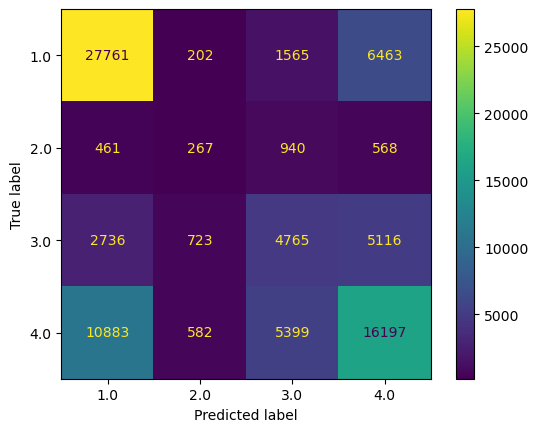

In [23]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test);

In [34]:
# Évaluation sur l'ensemble d'entraînement
train_preds = dt_clf.predict(X_train)
train_f1 = f1_score(y_train, train_preds, labels=[2], average=None)

# Évaluation sur l'ensemble de validation
test_preds = dt_clf.predict(X_test)
test_f1 = f1_score(y_test, test_preds, labels=[2], average=None)

print(f"Train F1 score (classe 2): {train_f1[0] * 100:.2f}%")
print(f"Validation F1 score (classe 2): {test_f1[0] * 100:.2f}%")

Train F1 score (classe 2): 50.00%
Validation F1 score (classe 2): 13.32%


In [ ]:
### TRAIN > Evaluations

In [35]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_train, train_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,129700,161,2329,11453
2.0,1390,4043,1961,1335
3.0,7850,1779,33301,10399
4.0,28116,1460,13143,90088


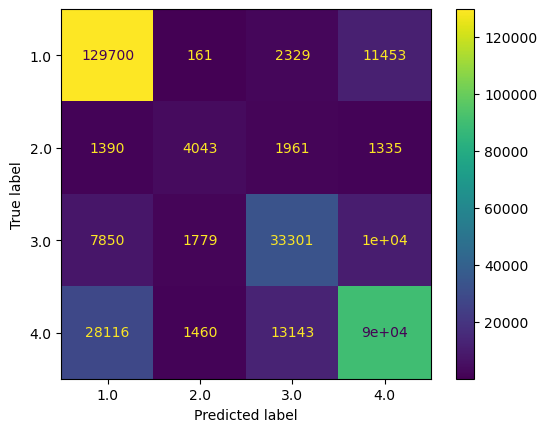

In [36]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_train,y_train);

In [37]:
# Rapport de classification
report_train = metrics.classification_report(y_train, train_preds)
print(report_train)

              precision    recall  f1-score   support

         1.0       0.78      0.90      0.83    143643
         2.0       0.54      0.46      0.50      8729
         3.0       0.66      0.62      0.64     53329
         4.0       0.80      0.68      0.73    132807

    accuracy                           0.76    338508
   macro avg       0.69      0.67      0.68    338508
weighted avg       0.76      0.76      0.76    338508



In [ ]:
### TEST > Evaluations

In [38]:
# Matrice de confusion sur l'ensemble de test
pd.crosstab(y_test, test_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,27761,202,1565,6463
2.0,461,267,940,568
3.0,2736,723,4765,5116
4.0,10883,582,5399,16197


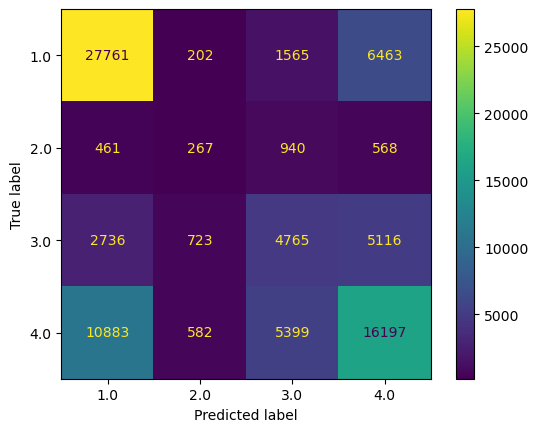

In [39]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test, y_test);

In [40]:
# Rapport de classification
report_test = metrics.classification_report(y_test, test_preds)
print(report_test)

              precision    recall  f1-score   support

         1.0       0.66      0.77      0.71     35991
         2.0       0.15      0.12      0.13      2236
         3.0       0.38      0.36      0.37     13340
         4.0       0.57      0.49      0.53     33061

    accuracy                           0.58     84628
   macro avg       0.44      0.43      0.44     84628
weighted avg       0.57      0.58      0.57     84628



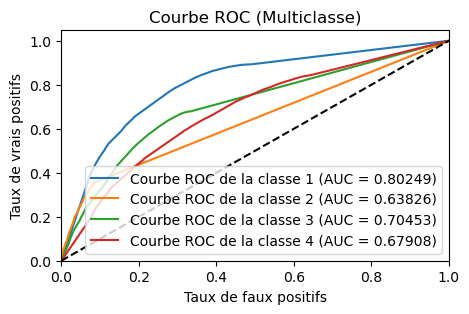

In [31]:
# Courbes ROC

# Binarisation des étiquettes dans un format one-vs-all
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
y_score = dt_clf.predict_proba(X_test)

n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcul de la courbe ROC et de l'AUC pour chaque classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

# Tracer de la courbe ROC pour chaque classe
plt.figure(figsize=(5, 3))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Courbe ROC de la classe {i+1} (AUC = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC (Multiclasse)')
plt.legend(loc="lower right")
plt.show()  

In [ ]:
### Tableau de résultats > Sauvegarde

In [127]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
df_param = resultats[colonnes_parametres]

# Renommage des colonnes de df_param
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres]
df_param.columns = noms_parametres

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_scoring = [col for col in resultats.columns if col.startswith('mean_test_')]
df_scoring = resultats[colonnes_scoring]

# Renommage des colonnes de df_scoring
noms_scoring = [col.replace('mean_test_', '') for col in colonnes_scoring]
df_scoring.columns = noms_scoring

# Concatenation des deux dataframe
df_resultat = pd.concat([df_param, df_scoring], axis=1)
df_resultat.head(10)

,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,random_state,splitter,score
0,gini,None,sqrt,1,1,128,best,0.131419
1,gini,None,sqrt,1,1,128,random,0.122078
2,gini,None,sqrt,1,2,128,best,0.131419
3,gini,None,sqrt,1,2,128,random,0.122078
4,gini,None,sqrt,1,4,128,best,0.131954
5,gini,None,sqrt,1,4,128,random,0.128894
6,gini,None,sqrt,1,8,128,best,0.122416
7,gini,None,sqrt,1,8,128,random,0.130944
8,gini,None,sqrt,1,16,128,best,0.127183
9,gini,None,sqrt,1,16,128,random,0.119621


In [128]:
# Sauvegarde des résultats
df_resultat.to_csv('dt_files/resultat_40.csv', index=False)  

### 5.0 - GridSearch - 2 classes - Métrique : F1 macro

In [3]:
# Import des librairies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib as jl
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, tree
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

In [39]:
# Lecture du fichier commun
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [41]:
# Regroupement des 4 classes en 2 classes : 0 = pas grave, 1 = grave
df_tree['grav'] = df_tree['grav'].replace({1: 0, 4: 0, 2: 1, 3: 1})

In [42]:
# Création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

In [43]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [44]:
# Comptage des valeurs distinctes de la colonne cible 'grav'
comptage_valeurs = df_tree['grav'].value_counts()
print(comptage_valeurs)

0.0    345502
1.0     77634
Name: grav, dtype: int64


In [45]:
# Nous avons un fort déséquilibre de classe, mais contrairement au multi-classe nous avons suffisament de valeurs dans la classe minoritaire pour se permettre un Undersampling à la place d'un Oversampling.

In [47]:
# UNDERSAMPLING de X_Train et y_train
undersampler = RandomUnderSampler(random_state=123)
X, y = undersampler.fit_resample(X_train, y_train)

In [50]:
# Définir les hyperparamètres et leurs distributions pour la recherche v2
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + [12, 14, 16, 18, 20, 22, 24, 32, 64],    
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "random_state": [128]                                               # Peu d'influence, on le fixe à 1 valeur pour réduire le temps d'exécution
}

In [51]:
# Instanciation de l'algorithme et du gridsearch
tree_class = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='f1_macro', error_score='raise')

In [52]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 47955.49058127403 secondes


In [53]:
# Sauvegarde 50 grid_search
grid_50 = 'grid_search_50.pkl'
jl.dump(grid_search, grid_50)

['grid_search_50.pkl']

In [115]:
# Récupération du modèle depuis sauvegarde 50 grid_search
grid_search = jl.load('grid_search_50.pkl')

In [54]:
# Recherche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 32,
 'random_state': 128,
 'splitter': 'random'}

In [55]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=32, max_features='sqrt', min_samples_split=32, min_samples_leaf=1, random_state=128, splitter='random')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=32, max_features='sqrt',
                       min_samples_split=32, random_state=128,
                       splitter='random')

In [56]:
# Sauvegarde 50 - dt_clf
filename_50 = 'dt_clf_50.pkl'
jl.dump(dt_clf, filename_50)

['dt_clf_50.pkl']

In [114]:
# Récupération du modèle depuis sauvegarde 50 dt_clf
dt_clf = jl.load('dt_clf_50.pkl')

In [78]:
# Évaluation sur l'ensemble d'entraînement et de validation

# Évaluation sur l'ensemble d'entraînement
train_preds = dt_clf.predict(X_train)
train_f1 = f1_score(y_train, train_preds, average='macro')

# Évaluation sur l'ensemble de validation
test_preds = dt_clf.predict(X_test)
test_f1 = f1_score(y_test, test_preds, average='macro')

print(f"Train F1 score (classe 2): {train_f1 * 100:.2f}%")
print(f"Validation F1 score (classe 2): {test_f1 * 100:.2f}%")

Train F1 score (classe 2): 74.96%
Validation F1 score (classe 2): 66.85%


In [ ]:
### TRAIN > Evaluations

In [61]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_train, train_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0.0,1.0
Classe réelle,,
0.0,265621,10829
1.0,32659,29399


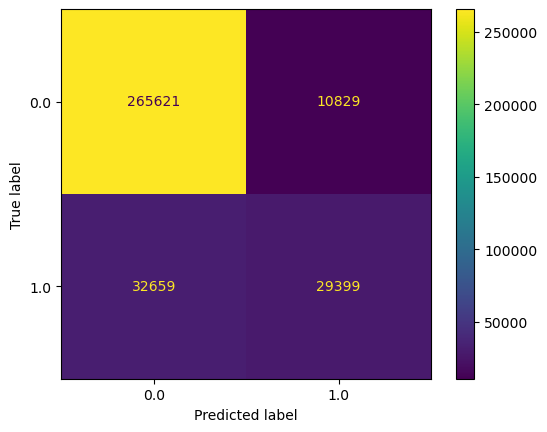

In [62]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_train,y_train);

In [63]:
# Rapport de classification
report_train = metrics.classification_report(y_train, train_preds)
print(report_train)

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92    276450
         1.0       0.73      0.47      0.57     62058

    accuracy                           0.87    338508
   macro avg       0.81      0.72      0.75    338508
weighted avg       0.86      0.87      0.86    338508



In [ ]:
### TEST > Evaluations

In [64]:
# Matrice de confusion sur l'ensemble de test
pd.crosstab(y_test, test_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0.0,1.0
Classe réelle,,
0.0,64598,4454
1.0,9968,5608


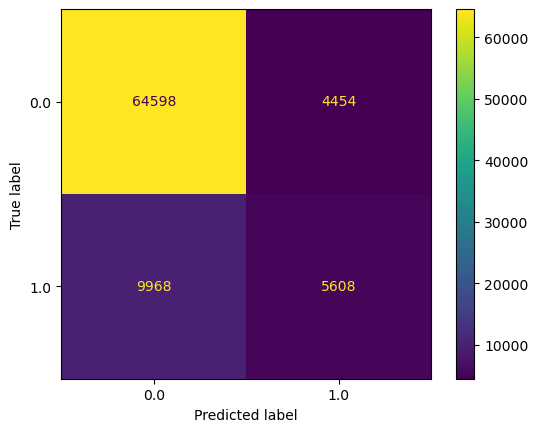

In [65]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test, y_test);

In [66]:
# Rapport de classification
report_test = metrics.classification_report(y_test, test_preds)
print(report_test)

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     69052
         1.0       0.56      0.36      0.44     15576

    accuracy                           0.83     84628
   macro avg       0.71      0.65      0.67     84628
weighted avg       0.81      0.83      0.81     84628



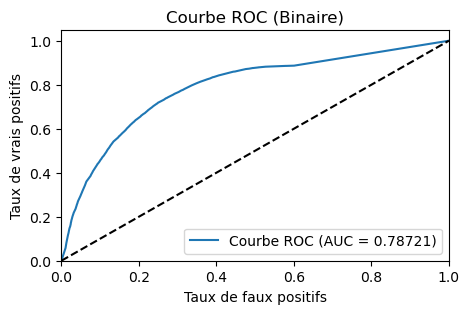

In [84]:
# Courbe ROC

# Prédictions de probabilités pour la classe positive
y_score = dt_clf.predict_proba(X_test)[:, 1]

# Calcul de la courbe ROC et de l'AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC (Binaire)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
### Tableau de résultats > Sauvegarde

In [118]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
df_param = resultats[colonnes_parametres]

# Renommage des colonnes de df_param
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres]
df_param.columns = noms_parametres

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_scoring = [col for col in resultats.columns if col.startswith('mean_test_')]
df_scoring = resultats[colonnes_scoring]

# Renommage des colonnes de df_scoring
noms_scoring = [col.replace('mean_test_', '') for col in colonnes_scoring]
df_scoring.columns = noms_scoring

# Concatenation des deux dataframe
df_resultat = pd.concat([df_param, df_scoring], axis=1)
df_resultat.head(10)

,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,random_state,splitter,score
0,gini,None,sqrt,1,1,128,best,0.646788
1,gini,None,sqrt,1,1,128,random,0.647902
2,gini,None,sqrt,1,2,128,best,0.646788
3,gini,None,sqrt,1,2,128,random,0.647902
4,gini,None,sqrt,1,4,128,best,0.648180
5,gini,None,sqrt,1,4,128,random,0.648841
6,gini,None,sqrt,1,8,128,best,0.654665
7,gini,None,sqrt,1,8,128,random,0.655582
8,gini,None,sqrt,1,16,128,best,0.656853
9,gini,None,sqrt,1,16,128,random,0.658415


In [119]:
# Sauvegarde des résultats
df_resultat.to_csv('dt_files/resultat_50.csv', index=False)